In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

import datetime

import requests
import arrow

import itertools

from dataclasses import dataclass

from shapely.geometry import MultiPolygon, Polygon, Point

from farsiteutils import User, Run_File, Config_File, Input, FilePaths, Database

from matplotlib import pyplot as plt

@dataclass
class Station:
    name: str
    lat: float
    lon: float
    temperature: list
    wind_speed: list
    wind_direction: list
    timestamp: list
    units: dict

description = 'Maria2019'
gdf = pd.read_pickle(f'/home/jovyan/farsite-devAPI/src/{description}_simulation.pkl')
dftable = pd.read_pickle('/home/jovyan/data/test_table.pkl')

# Table 1 - ignition
gdfignition = gpd.GeoDataFrame(dftable[dftable['filetype'] == 'Ignition'])
for (idx, ignition) in gdfignition.iterrows():
    geom = gpd.read_file(ignition['filepath']).loc[0,'geometry']
    gdfignition.loc[idx, 'shape'] = geom.to_wkb()

gs = gpd.GeoSeries.from_wkb(gdfignition['shape'])
gdfignition['geometry'] = gs
gdfignition = gdfignition.drop(columns='shape').set_crs(epsg=5070)

gdfignition = gdfignition[gdfignition['description'] == description]

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_376/1209152900.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling 

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/farsite-devAPI/src/Maria2019_simulation.pkl'

In [2]:
# gdf = gdf.set_crs(epsg=5070, allow_override=True).to_crs(epsg=4326)

centerlat = gdfignition.to_crs(epsg=4326)['geometry'].iloc[5].centroid.y
centerlon = gdfignition.to_crs(epsg=4326)['geometry'].iloc[5].centroid.x

from ipyleaflet import Map, basemaps, WKTLayer

m = Map(
    basemap=basemaps.Esri.WorldTopoMap,
    center=(centerlat, centerlon),
    zoom=10,
)
m

Map(center=[34.31171483477073, -119.05484252970128], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [3]:
for layer in m.layers:
    if isinstance(layer, WKTLayer):
        m.remove_layer(layer)
        
    
# mpolygon = shapely.geometry.MultiPolygon(polygons=[gdf['geometry'].iloc[1], gdf['geometry'].iloc[2], gdf['geometry'].iloc[3]])
# m.add_layer(WKTLayer(wkt_string = mpolygon.wkt))
m.add_layer(WKTLayer(wkt_string = gdfignition.to_crs(epsg=4326)['geometry'].iloc[0].wkt))


In [4]:
def collect_wx_data(gdf, gdfignition, igniteidx, compareidx):
    km_per_miles = 1.60934

    ignite = gdfignition.to_crs(epsg=4326).loc[igniteidx]
    compare = gdfignition.to_crs(epsg=4326).loc[compareidx]

    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = ignite['geometry'].centroid.x
    lat = ignite['geometry'].centroid.y
    radius = 5*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

    fromdt = ignite['datetime'].tz_localize('US/Pacific')
    todt = compare['datetime'].tz_localize('US/Pacific')
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    r_json = r.json()

    stations_lst = []
    for feature in r_json['features']:

        lon,lat = feature['geometry']['coordinates']

        name = feature['properties']['description']['name']
        wxid = feature['properties']['description']['id']
        provider = feature['properties']['description']['provider']
        wifire_uid = feature['properties']['description']['wifire_uid']

        timestamp = pd.to_datetime(feature['properties']['timestamp'])
        try:
            temperature = feature['properties']['temperature']
        except KeyError:
            temperature = []

        try:
            wind_speed = feature['properties']['wind_speed']
        except KeyError:
            wind_speed = []

        try:
            wind_direction = feature['properties']['wind_direction']
        except KeyError:
            wind_direction = []

        units = feature['properties']['units']

        stations_lst.append(Station(name, lat, lon, temperature, wind_speed, wind_direction, timestamp, units))
        
    return stations_lst

In [8]:
import requests
from pprint import pprint#import pretty print

baseURL = "https://firemap.sdsc.edu/pylaski/stations/data/latest?"
## Always start with the base of the URL
closestTo&lat=&lon=-119.0686&
selectionType="selection=closestTo"
lat = 38.8977
lon = -77.0365
## Latitude and longitude of the White House according to Google
selectionParameters = "&lat=%s&lon=%s&observable=temperature" % (str(lat),str(lon))

infoURL = baseURL + selectionType + selectionParameters

r = requests.get(infoURL)
## Request to GET information from the given URL (Our REST query we built)
r_json = r.json()
## Extract the JSON object from the data returned on our GET request

pprint(r_json)

{'features': [{'geometry': {'coordinates': [-119.0686, 35.31783],
                            'type': 'Point'},
               'properties': {'description': {'id': '178302',
                                              'name': 'Bakersfield IDSM',
                                              'provider': 'Mesowest',
                                              'wifire_uid': 'mesowest_445pg'},
                              'distanceFromLocation': {'units': 'km',
                                                       'value': 0.0},
                              'relative_humidity': {'timestamp': '2024-03-15 '
                                                                 '14:00:00-0700',
                                                    'units': '%',
                                                    'value': 29.35},
                              'temperature': {'timestamp': '2024-03-15 '
                                                           '14:00:00-0700',
                  

In [7]:
infoURL

'https://firemap.sdsc.edu/pylaski/stations/data/latest?selection=closestTo&lat=38.8977&lon=-77.0365&observable=temperature'

In [18]:
def collect_station_comparison(stations_lst, ws_optimal, wd_optimal, igniteidx, compareidx):
    ws_lst = []
    wd_lst = []
    pdiff_wslst = []
    diff_wdlst = []
    station_name = []
    timestamps = []
    geometry = []

    for station in stations_lst:
        try:
            for ix in range(len(station.wind_speed)):
                ws = station.wind_speed[ix]
                wd = station.wind_direction[ix]
                tp = station.timestamp[ix]

                if (ws != None) & (wd != None):
                    wsdiff = (ws_optimal - ws)/ws
                    wddiff = (wd_optimal - wd)
                    break
                
    #         ws = station.wind_speed[0]
    #         wd = station.wind_direction[0]
        except IndexError:
            print(f'Skipping {station.name}. No data found!')
            ws = None
            wd = None
            wsdiff = None
            wddiff = None
            tp = None
            
        ws_lst.append(ws)
        wd_lst.append(wd)
        pdiff_wslst.append(wsdiff)
        diff_wdlst.append(wddiff)
        station_name.append(station.name)
        timestamps.append(tp)
        geometry.append(Point(station.lon, station.lat))
        
    gdf = gpd.GeoDataFrame(data={'station_name': station_name,
                                 'timestamp': timestamps,
                                 'wsdiff': pdiff_wslst,
                                 'wddiff': diff_wdlst,
                                 'wsoptimal': ws_optimal,
                                 'wdoptimal': wd_optimal, 
                                 'ws': ws_lst,
                                 'wd': wd_lst},
                           crs='EPSG:4326',
                           geometry=geometry)    
            
    gdf['igniteidx'] = igniteidx
    gdf['compareidx'] = compareidx
    
    return gdf.reset_index(drop=True)

In [19]:
%%time

ignitionidx_lst = gdf['igniteidx'].unique()
gdfResults = gpd.GeoDataFrame()

for (ix, igniteidx) in enumerate(ignitionidx_lst):
    print(f'Calculating {ix+1}/{len(ignitionidx_lst)}...   ', end='\r', flush=True)
    
    ignition = gdfignition.loc[igniteidx, 'geometry']
    compareidx = gdf.loc[(gdf['igniteidx'] == igniteidx), 'compareidx'].iloc[0]
    geom_compare = gdfignition.loc[compareidx, 'geometry']
    
    gdfSub = gdf[gdf['igniteidx'] == ignition]

    gdf['area'] = (gdf['geometry'].union(geom_compare).difference(gdf['geometry'].intersection(geom_compare))).area
    idxmin = gdf['area'].idxmin()

    ws_optimal = gdf.loc[idxmin, 'windspeed']
    wd_optimal = gdf.loc[idxmin, 'winddirection']    # Degrees
        
    stations_lst = collect_wx_data(gdf, gdfignition, igniteidx, compareidx)
    
    gdfResults = gdfResults.append(collect_station_comparison(stations_lst, ws_optimal, wd_optimal, igniteidx, compareidx))

gdfResults = gdfResults.reset_index(drop=True).dropna()
gdfResults['description'] = description

https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.31984085482566&lon=-119.03909139010659&radius=8.0467&observable=temperature&observable=wind_speed&observable=wind_direction&from=2019-10-31T19:27:11-07:00&to=2019-10-31T20:08:22-07:00
Skipping CW7664 Santa Paula. No data found!
https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.31448975046042&lon=-119.04499757335797&radius=8.0467&observable=temperature&observable=wind_speed&observable=wind_direction&from=2019-10-31T19:48:22-07:00&to=2019-10-31T20:41:33-07:00
Skipping CW7664 Santa Paula. No data found!
https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.31184252986053&lon=-119.04907712017159&radius=8.0467&observable=temperature&observable=wind_speed&observable=wind_direction&from=2019-10-31T20:21:33-07:00&to=2019-10-31T21:06:44-07:00
Skipping CW7664 Santa Paula. No data found!
https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.30974500

In [2]:
# gdfResults.to_pickle('./Bridge2021_compare.pkl')
gdfResults = pd.read_pickle('./Maria2019_compare.pkl')

In [57]:
indices = gdfignition.sort_values('datetime').index
stations = gdfResults['station_name'].unique()
stations_discard = []
for station in stations:
    pointcount = (gdfResults['station_name'] == station).sum()
    print(f'{station}: has {pointcount} points')
    
    if pointcount < 5:
        stations_discard.append(station)
        print(f'\tRemoving {station}')

gdfResultsDropped = gdfResults[~gdfResults['station_name'].isin(stations_discard)]

# First timepoint
stations_dropped = gdfResultsDropped['station_name'].unique()
indices_dropped = gdfResultsDropped['igniteidx'].unique()
for index in indices_dropped:
    gdfResultsDropped.loc[(gdfResultsDropped['igniteidx'] == index), 'datetime'] = gdfignition.loc[index, 'datetime']

indices_dropped = gdfResultsDropped.sort_values(['station_name', 'datetime'])['igniteidx'].unique()    
    
alpha_dict = {}
for station in stations_dropped:
    alpha_dict[station] = {}
    for (ix, index) in enumerate(indices_dropped):
        alpha_dict[station][ix] = []
        
predictions = {}
for (ix, index) in enumerate(indices_dropped):
    predictions[ix+1] = []

for (ix, index) in enumerate(indices_dropped[:-1]):
    combinations = tuple(itertools.combinations(stations_dropped,ix+1))
    for combination in combinations:
        # Select station
        X = np.zeros((len(combination), len(combination)))
        Xnext = np.zeros((1, len(combination)))
        
        for (six, station) in enumerate(combination):
            X[:,six] = gdfResultsDropped[gdfResultsDropped['igniteidx'].isin(indices_dropped[:(ix+1)]) & 
                                         (gdfResultsDropped['station_name'] == station)]['ws']
            
            
        wopt = gdfResultsDropped[gdfResultsDropped['igniteidx'].isin(indices_dropped[:(ix+1)]) & 
                                     (gdfResultsDropped['station_name'] == station)]['wsoptimal']
        
        alpha = np.linalg.solve(X, wopt)
        
        for (six, station) in enumerate(combination):
            Xnext[0,six] = gdfResultsDropped[gdfResultsDropped['igniteidx'].isin([indices_dropped[ix+1]]) & 
                                         (gdfResultsDropped['station_name'] == station)]['ws']
        wpred = np.dot(Xnext, alpha)
        predictions[ix+1].append(wpred[0])
        
        for (six, station) in enumerate(combination):
            alpha_dict[station][ix].append(alpha[six])

Santa Paula: has 5 points
South Mountain West: has 5 points
SCE Bradley Rd: has 5 points
SCE South Mountain: has 5 points
SCE Balcom Canyon: has 5 points
SCE Bixby Rd: has 2 points
	Removing SCE Bixby Rd
SCE Camarillo Hills: has 5 points
SCE Santa Paula: has 5 points
SCE Hondo Barranca Rd: has 5 points
SCE North Peck Rd: has 5 points
SOMIS (P729) CA: has 4 points
	Removing SOMIS (P729) CA
SCE El Rio: has 3 points
	Removing SCE El Rio


NameError: name 'woptimal' is not defined

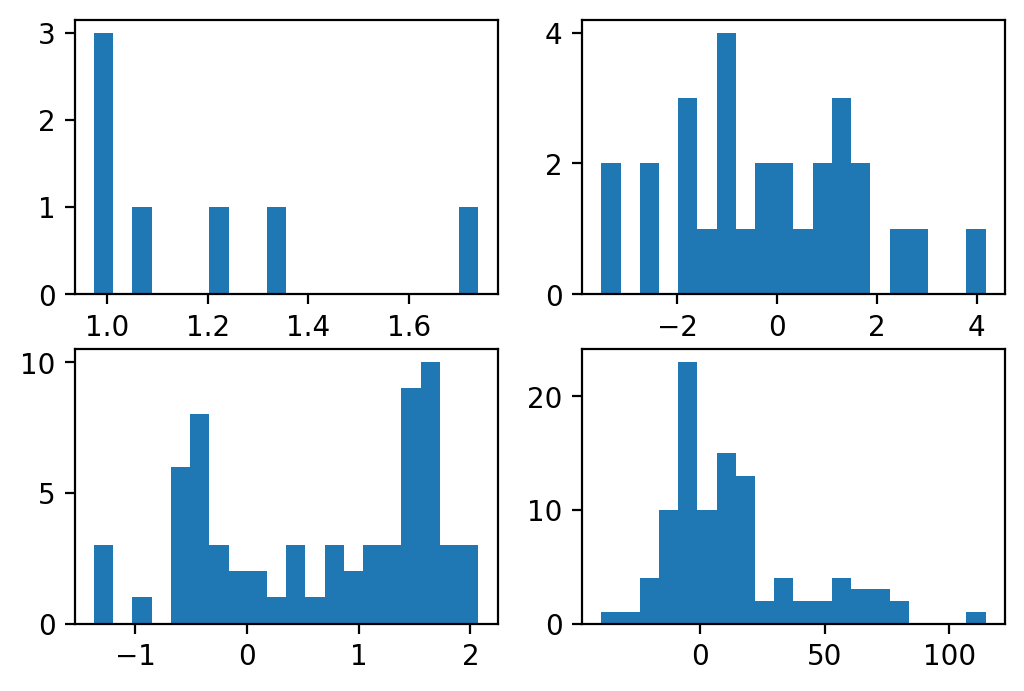

In [76]:
fig, axes2d = plt.subplots(2,2, figsize=(6,4), dpi=200)

axes = axes2d.flatten()

for (ix, ax) in enumerate(axes):
    
    wpreds = np.array(predictions[ix+1])

    qsmall, qbig = np.percentile(wpreds, [10, 90])

    values_iqr = wpreds[(wpreds >= qsmall) & (wpreds <= qbig)]
    
    woptimal = wopt.iloc[ix]
    
    ax.hist(values_iqr, bins=20)
#     ax.plot([woptimal, woptimal], [0, 1], 'k--')
#     ax.set_title(f'Timepoint {ix}')
    
#     ax.set_xlim(-20,20)

In [71]:
wopt

10     1.0
22     0.0
34     1.0
46    18.0
Name: wsoptimal, dtype: float64

(-10.0, 10.0)

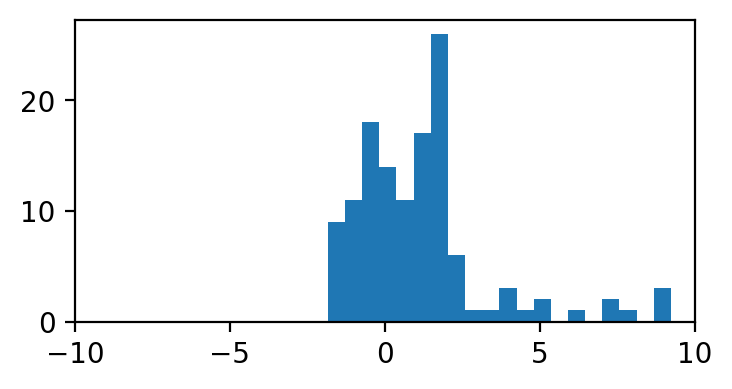

In [53]:
from matplotlib import pyplot as plt

# ix = 1
# print(stations_dropped[ix])
# values = np.array(alpha_dict[stations_dropped[ix]])
values = np.array(predictions)

q10, q90 = np.percentile(values, [25, 75])

values_iqr = values[(values >= q10) & (values <= q90)]

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.hist(values_iqr, bins=20)

ax.set_xlim(-10,10)


(array([ 7.,  1., 32., 63., 12.,  5.,  4.,  2.,  2.,  1.]),
 array([-37.5835466 , -27.61743968, -17.65133277,  -7.68522585,
          2.28088106,  12.24698798,  22.21309489,  32.17920181,
         42.14530872,  52.11141564,  62.07752255]),
 <a list of 10 Patch objects>)

In [73]:
gdfResultsDropped[gdfResultsDropped['igniteidx'].isin(indices_dropped[:(ix+1)]) & 
                                         (gdfResultsDropped['station_name'].isin(combination))]

,station_name,wsdiff,wddiff,wsoptimal,wdoptimal,ws,wd,geometry,igniteidx,compareidx,description,datetime
0,Santa Paula,-0.428571,30.0,1.0,55.0,1.75,25.0,POINT (-119.10417 34.32500),f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:37:11
2,South Mountain West,-0.137931,-117.0,1.0,55.0,1.16,172.0,POINT (-119.09333 34.28278),f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:37:11
11,Santa Paula,-1.000000,-25.0,0.0,0.0,1.75,25.0,POINT (-119.10417 34.32500),9f82e870591748a9a8a01346d174f2a1,1a6eb30ee33742e18fa6bb26678b5077,Maria2019,2019-10-31 19:58:22
13,South Mountain West,-1.000000,-160.0,0.0,0.0,1.43,160.0,POINT (-119.09333 34.28278),9f82e870591748a9a8a01346d174f2a1,1a6eb30ee33742e18fa6bb26678b5077,Maria2019,2019-10-31 19:58:22


In [27]:
len(combintaions)

792

## Linear regression

Calculate the optimal wind speed $w^k_{opt}$ from comparing the simulated perimeter $P_i^k$ and the ignition $I^k$ for timepoint $k$. Then, construct the linear regression system for all the previous timepoints up to $k$:
$$\vec{w_{opt}} = X\vec{\alpha}$$,

where $\vec{w_{opt}}$ is a $k$-degree vector with the optimal wind speed for each $k$ timepoint, $X$ is a $k\times L$ matrix for each $k$ timepoints and $L$ weather stations, and $\vec{\alpha}$ is a $L\times 1$ vector with coefficients for each $L$ weather station.

The progression is to run the optimization for each timepoint, for all weather stations, and measure accuracy from the difference between the $w_{pred}^k$ and $w_{opt}^k$. We can also measure the convergence from the $\vec{\alpha}$ trajectory for each timepoint calculation

In [3]:
df = pd.read_pickle('./Maria2019_compare.pkl')

In [5]:
Xl = df[df['station_name'] == 'Santa Paula']['ws'] 
wopt = df[df['station_name'] == 'Santa Paula']['wsoptimal']


,station_name,wsdiff,wddiff,wsoptimal,wdoptimal,ws,wd,geometry,igniteidx,compareidx,description
0,Santa Paula,-0.428571,30.0,1.0,55.0,1.75,25.0,POINT (-119.10417 34.32500),f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019
11,Santa Paula,-1.000000,-25.0,0.0,0.0,1.75,25.0,POINT (-119.10417 34.32500),9f82e870591748a9a8a01346d174f2a1,1a6eb30ee33742e18fa6bb26678b5077,Maria2019
23,Santa Paula,-0.797571,10.0,1.0,15.0,4.94,5.0,POINT (-119.10417 34.32500),1a6eb30ee33742e18fa6bb26678b5077,911f9b001c054b74a6ba70958f5f3c93,Maria2019
35,Santa Paula,2.643725,85.0,18.0,90.0,4.94,5.0,POINT (-119.10417 34.32500),911f9b001c054b74a6ba70958f5f3c93,7957c2e604554199ba60c5b13aff2f40,Maria2019
47,Santa Paula,0.971831,-212.0,7.0,145.0,3.55,357.0,POINT (-119.10417 34.32500),7957c2e604554199ba60c5b13aff2f40,714f0cf8d475462a97c651642a3d2525,Maria2019


In [99]:
X_all = np.zeros((gdfResults['igniteidx'].nunique(), gdfResults['station_name'].nunique()))
stations_lst = gdfResults['station_name'].unique()

skip_station_ix = []
for (ix, station) in enumerate(stations_lst):
    gdfResultsPerStation = gdfResults[gdfResults['station_name'] == station]
    
    try:
        X_all[:, ix] = gdfResultsPerStation['ws']
    except ValueError:
        print(f'Skipping {station}')
        skip_station_ix.append(ix)

station = 'Santa Paula'
gdfResultsPerStation = gdfResults[gdfResults['station_name'] == station]
w_opt_all = gdfResultsPerStation['wsoptimal'].values

Skipping SCE Bixby Rd
Skipping SOMIS (P729) CA
Skipping SCE El Rio


In [100]:
X_all_skipped = np.zeros((gdfResults['igniteidx'].nunique(), (len(stations_lst)-len(skip_station_ix))))

reworked_ix = 0
for ix in range(len(stations_lst)):
    if skip_station_ix.count(ix) == 0:
        X_all_skipped[:,reworked_ix] = X_all[:,ix]
        reworked_ix += 1

In [103]:
X_all_skipped.shape

(5, 9)

In [104]:
alpha_all = []
for ix in range(len(w_opt_all)):  # For each timepoint
    w_opt = w_opt_all[ix]
    X = X_all_skipped[ix, :]
    
    break

3.0

In [37]:
fp = FilePaths('/home/tcaglar/data/')
usr = User(fp)
usr.m

Database interaction not yet implemented. Use pickle file for dataframes instead!
Setting up the interface


Map(center=[34.178861487501464, -118.566380281569], controls=(AttributionControl(options=['position', 'prefix'…

In [36]:
igniteidx = 'f23196b034474744bdca7df94b13e0f7'
for (idx, row) in gdf[(gdf['igniteidx'] == igniteidx) & (gdf['windspeed'] == 19)].to_crs(epsg=4326).iloc[[0,5,10, 15]].iterrows():
    usr.m.add_layer(WKTLayer(wkt_string=row['geometry'].wkt, style={'color': '#ff0000', 'fill_opacity':0.1}))


In [13]:
def clickEvent(**kwargs):
    clayer = kwargs['clayer']
    station = kwargs['station']
    
    print(station.name)

In [14]:
from ipyleaflet import Circle
from functools import partial

# Remove WX layers
for layer in usr.m.layers:
    if isinstance(layer, Circle):
        usr.m.remove_layer(layer)

for station in stations_lst:
#     notfound = True
#     for st in stationlst:
#         if station.name == st:
#             notfound = False
#             break
#     if notfound:
#         continue
        
    clayer = Circle(radius=400, location=(station.lat, station.lon), stroke=False, fill_color='#000000', fill_opacity=1)
    clayer.on_click(partial(clickEvent, station=station, clayer=clayer))
    usr.m.add_layer(clayer)

Text(0.5, 1.0, 'Degree Diff')

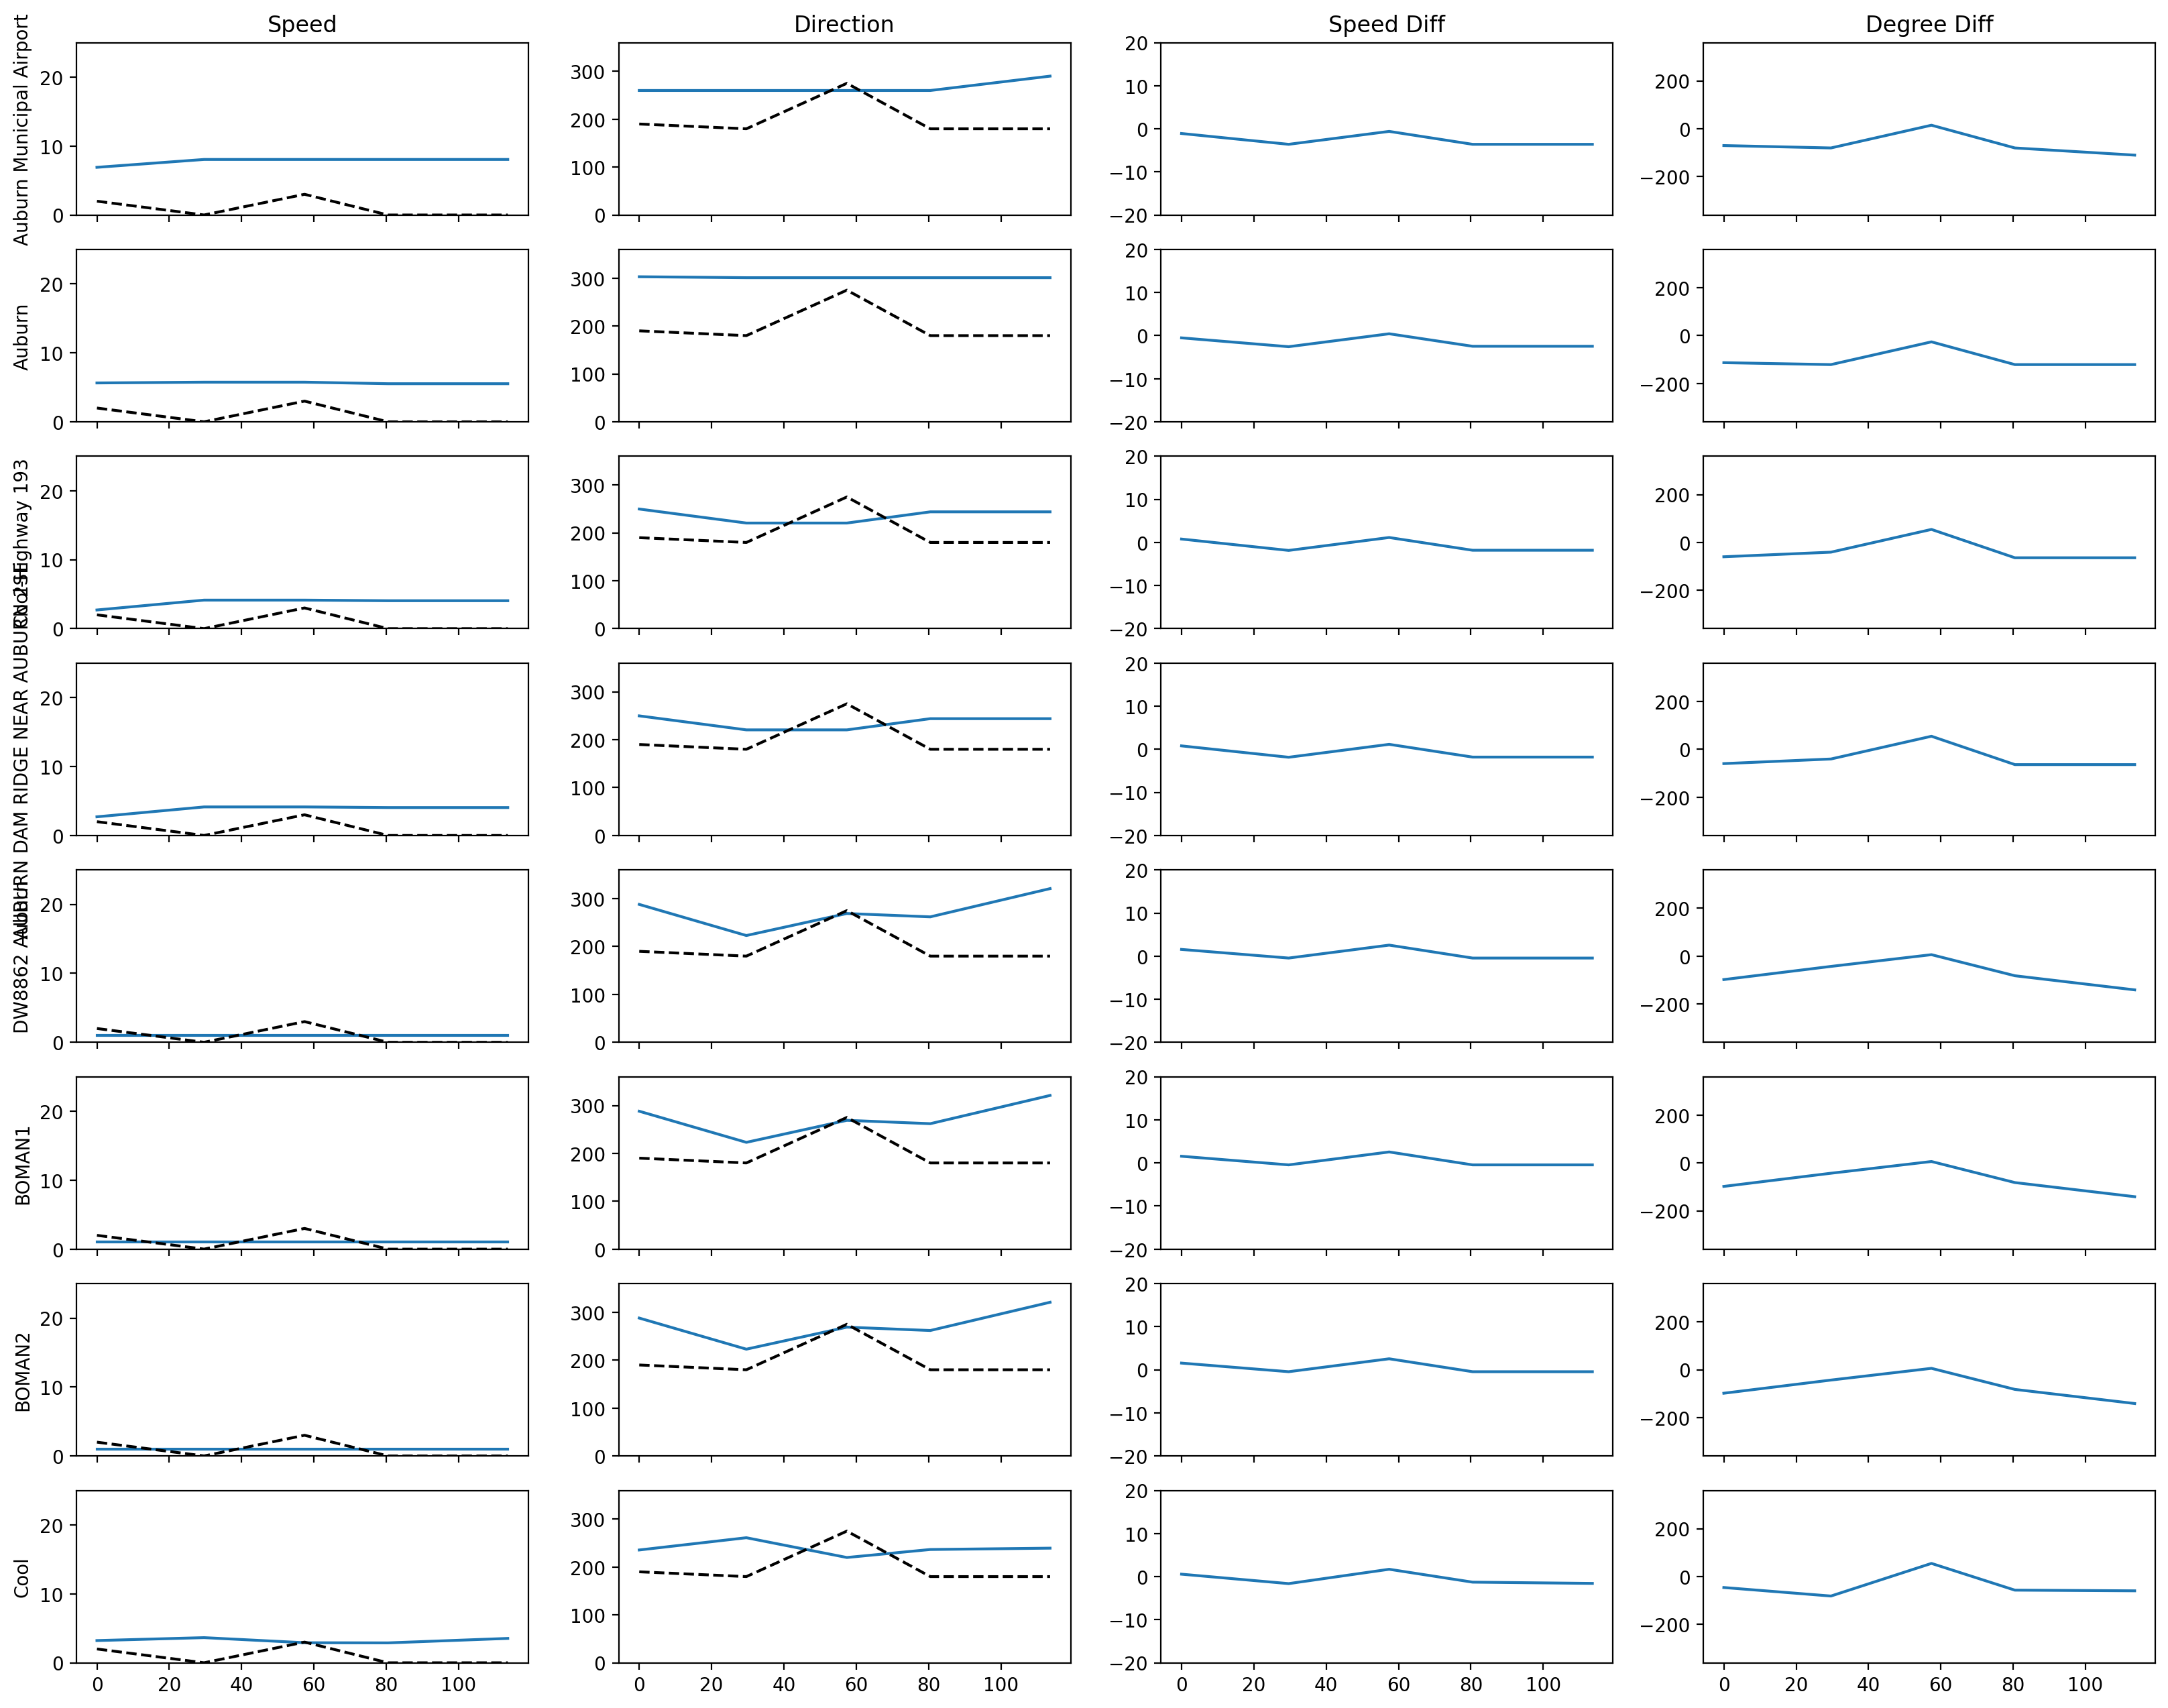

In [69]:
ignitelst = gdfResults['igniteidx'].unique().tolist()
# stationlst = gdfResults['station_name'].unique().tolist()
stationlst = gdfCombined['station_name'].unique()

fig, axes = plt.subplots(len(stationlst),4, figsize=(4*5,2*len(stationlst)), dpi=200, sharex=True)

for (ix, station) in enumerate(stationlst):
    print(f'Calculating {ix}/{len(stationlst)}...    ', end='\r', flush=True)
    gdfResultStation = gdfResults[gdfResults['station_name'] == station]

    deg = gdfResultStation['wd']
    ws = gdfResultStation['ws']
    u = ws*np.cos(deg*np.pi/180)
    v = ws*np.sin(deg*np.pi/180)

    wsopt = gdfResultStation['wsoptimal']
    degopt = gdfResultStation['wdoptimal']
    uopt = wsopt*np.cos(degopt*np.pi/180)
    vopt = wsopt*np.sin(degopt*np.pi/180)

    wsdiff = (wsopt - ws)
    wddiff = (degopt - deg)
#     udiff = (uopt - u)/uopt
#     vdiff = (vopt - v)/vopt

    dt = gdfignition.loc[gdfResultStation['igniteidx'], 'datetime']
    deltadt = np.array([(t-dt.iloc[0]).total_seconds()/60 for t in dt.values])

    axes[ix, 0].plot(deltadt, np.abs(ws*2.23694))
    axes[ix, 0].plot(deltadt, wsopt, 'k--')
    axes[ix, 0].set_ylim(0,25)
    
    axes[ix, 1].plot(deltadt, np.abs(deg))
    axes[ix, 1].plot(deltadt, degopt, 'k--')
    axes[ix, 1].set_ylim(0, 360)
    
    axes[ix, 2].plot(deltadt, wsdiff)
    axes[ix, 2].set_ylim(-20, 20)
    
    axes[ix, 3].plot(deltadt, wddiff)
    axes[ix, 3].set_ylim(-360, 360)
    
#     axes[ix, 4].plot(deltadt, np.abs(vdiff))
#     axes[ix, 4].set_ylim(0, 3)
    
    axes[ix, 0].set_ylabel(station)
    
    
    
    
axes[0,0].set_title('Speed')
axes[0,1].set_title('Direction')
axes[0,2].set_title('Speed Diff')
axes[0,3].set_title('Degree Diff')
# axes[0,4].set_title('V Diff')

#     axes[ix, 0].plot(deltadt, np.abs(wsdiff), label=station)
    
# ax.set_xlabel('Minutes after first ignition')
# ax.set_ylabel('Diff in WindSpeed')
# ax.set_title(station)

# ax.set_ylim(0,3)
# ax.legend()

### Check station SCE Camarillo Hills:

In [66]:
gdfCombined = gdfResults
gdfCombined['wsopt_predict'] = None
gdfCombined['wsdiff_std'] = None
gdfCombined['deltadt'] = None


dt = gdfignition.loc[ignitelst, 'datetime']
deltadt = np.array([(t-dt.iloc[0]).total_seconds()/60 for t in dt.values])
deltadt

for station in stationlst:
#     station = 'SCE Camarillo Hills'
    gdf = gdfCombined[gdfCombined['station_name'] == station]
    
    if len(gdf) < len(ignitelst):  # Skip if shorter than 5
        continue
        
    for i in range(1, len(deltadt)-1):
        # Previously collected data
        wsdiff_mean = gdf['wsdiff'].iloc[:(i+1)].mean()
        wsdiff_std = gdf['wsdiff'].iloc[:(i+1)].std()
        
        # Predicting based on measured windspeed
        atdt = deltadt[i+1]
        atws = gdf['ws'].iloc[i+1]
        wsopt_predict = atws*(1+wsdiff_mean)
        idx = gdf.iloc[i+1].name
        gdfCombined.loc[idx, 'wsopt_predict'] = wsopt_predict
        gdfCombined.loc[idx, 'wsdiff_std'] = wsdiff_std
        gdfCombined.loc[idx, 'deltadt'] = atdt

    gdfCombined['predict_error'] = (gdfCombined['wsopt_predict'] - gdfCombined['wsoptimal'])
#     gdfCombined['predict_error'] = (gdfCombined['wsopt_predict'] - gdfCombined['wsoptimal'])/gdfCombined['wsoptimal']
    

In [67]:
gdfResultStation

,station_name,wsdiff,wddiff,wsoptimal,wdoptimal,ws,wd,geometry,igniteidx,compareidx,description,wsopt_predict,wsdiff_std,deltadt,predict_error
10,Andregg Road,0.369863,-99.7,2,190,1.46,289.7,POINT (-121.07581 38.85754),1943c4f73e9949bd9226acd86000101f,d588064eaa4545fea0463c2984f24e94,Bridge2021,None,None,None,NaN


Text(0.5, 1.0, 'Error')

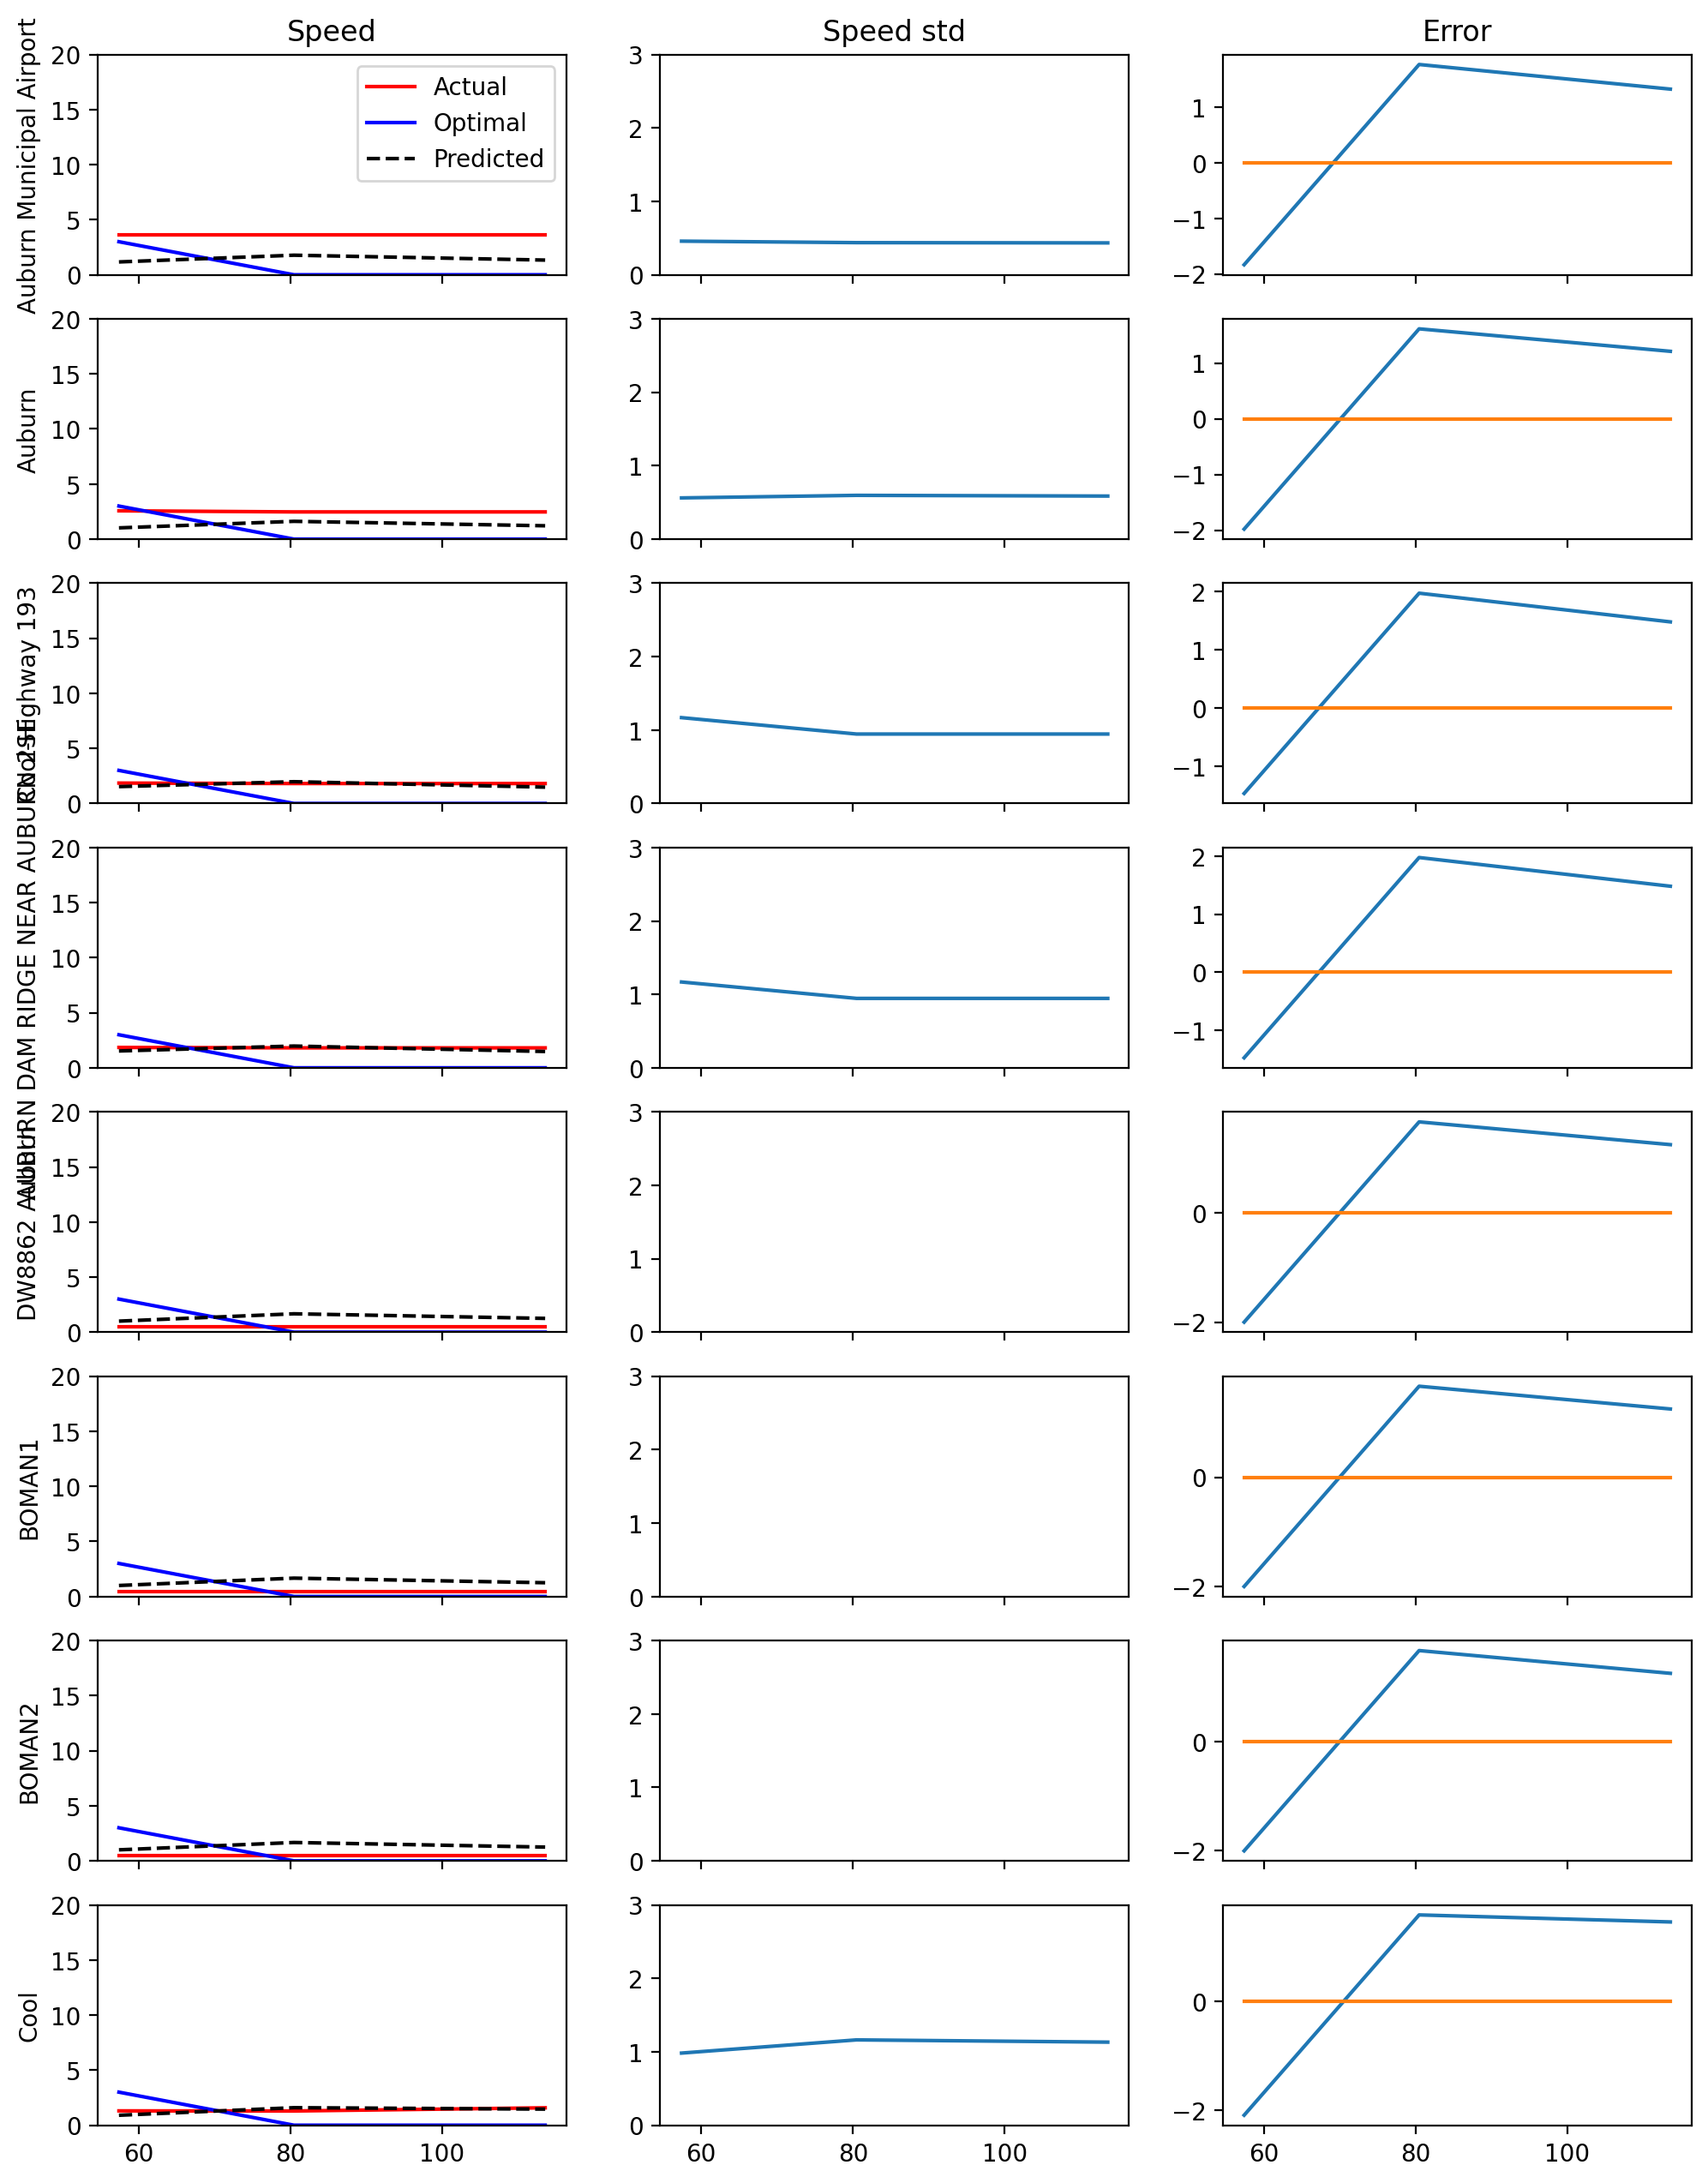

In [68]:
# gdfCombined = gdfResults
gdfCombined = gdfCombined.dropna()

ignitelst = gdfCombined['igniteidx'].unique().tolist()
stationlst = gdfCombined['station_name'].unique().tolist()
fig, axes = plt.subplots(len(stationlst),3, figsize=(4*3,2*len(stationlst)), dpi=200, sharex=True)

for (ix, station) in enumerate(stationlst):
    print(f'Calculating {ix}/{len(stationlst)}...    ', end='\r', flush=True)
    gdfResultStation = gdfResults[gdfResults['station_name'] == station]

    ws = gdfResultStation['ws']
    wsopt = gdfResultStation['wsoptimal']
    wsopt_predict = gdfResultStation['wsopt_predict']
    wsdiff_std = gdfResultStation['wsdiff_std']
    predict_error = gdfResultStation['predict_error']

    deltadt = gdfResultStation['deltadt']

    axes[ix, 0].plot(deltadt, ws, 'r-', label='Actual')
    axes[ix, 0].plot(deltadt, wsopt, 'b-', label='Optimal')
    axes[ix, 0].plot(deltadt, wsopt_predict, 'k--', label='Predicted')
    axes[ix, 0].set_ylim(0,20)
    
#     axes[ix, 1].plot(deltadt, wsopt)
#     axes[ix, 1].set_ylim(0, 15)
    
#     axes[ix, 2].plot(deltadt, wsopt_predict)
#     axes[ix, 2].set_ylim(0, 15)
    
    axes[ix, 1].plot(deltadt, wsdiff_std)
    axes[ix, 1].set_ylim(0, 3)
    
    axes[ix, 2].plot(deltadt, predict_error)
#     axes[ix, 2].set_ylim(-2,2)
    axes[ix, 2].plot([deltadt.iloc[2], deltadt.iloc[-1]], [0,0])

    axes[ix, 0].set_ylabel(station)
    
    
    
    
axes[0,0].set_title('Speed')
axes[0,0].legend()
# axes[0,1].set_title('Optimal')
# axes[0,2].set_title('Predicted')
axes[0,1].set_title('Speed std')
axes[0,2].set_title('Error')

#     axes[ix, 0].plot(deltadt, np.abs(wsdiff), label=station)
    
# ax.set_xlabel('Minutes after first ignition')
# ax.set_ylabel('Diff in WindSpeed')
# ax.set_title(station)

# ax.set_ylim(0,3)
# ax.legend()

In [ ]:
plt.plot([deltadt.iloc[2], deltadt.iloc[-1]], [0,0])

In [ ]:
[deltadt.iloc[0], deltadt.iloc[-1]]

In [ ]:
ws

In [ ]:
ws

In [ ]:
mns = []
stds = []
wscorrected = []
for i in range(1,len(wsdiff)):
    mn = wsdiff[:(i+1)].mean()    # Calculate wsdiff up to point i+1
    std = wsdiff[:(i+1)].std()    
    wsopt = wsoptimal.iloc[i]
    
    wscorrection = wsopt*(1+mn)
    wscorrected.append(wscorrection)
    
    mns.append(mn)
    stds.append(std)

In [ ]:
dt = gdfignition.loc[gdf['igniteidx'], 'datetime']
deltadt = np.array([(t-dt.iloc[0]).total_seconds()/60 for t in dt.values])

In [ ]:
deltadt

In [ ]:
gdf['wsoptimal']

In [ ]:
gdf['wsoptimal']*(1+wsdiff)

In [ ]:
gdf['ws']